In [2]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers


In [3]:
data_dir = 'paddy/'

In [4]:
data_dir

'paddy/'

In [5]:
import pathlib
data_dir=pathlib.Path(data_dir)
data_dir

WindowsPath('paddy')

In [6]:
list(data_dir.glob("*DSC*.jpg"))

[]

In [7]:
bacteria=list(data_dir.glob("bacterial blight/*"))
len(bacteria)

31

In [8]:
brown=list(data_dir.glob("brown leaf spot/*"))
len(brown)

35

In [9]:
smut=list(data_dir.glob("false smut/*"))
len(smut)

35

In [10]:
sheath=list(data_dir.glob("sheath/*"))
len(sheath)

28

In [11]:
blast=list(data_dir.glob("Blast/*"))
len(blast)

33

In [12]:
dict = {
    "bacteria": bacteria,
    "brown": brown,
    "smut": smut,
    "sheath": sheath,
    "blast": blast
}

labels_dict = {
    "bacteria": 0,
    "brown": 1,
    "smut": 2,
    "sheath": 3,
    "blast": 4
}

In [13]:
img=cv2.imread(str((dict["smut"][0])))

In [14]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [15]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15, # Rotate the image randomly between 0-15 degrees
    width_shift_range=0.1, # Shift the image horizontally by up to 10% of the image width
    height_shift_range=0.1, # Shift the image vertically by up to 10% of the image height
    shear_range=0.1, # Apply shearing transformations to the image
    zoom_range=0.1, # Apply zooming transformations to the image
    horizontal_flip=True, # Flip the image horizontally
    vertical_flip=True # Flip the image vertically
)

X = []
y = []

for name, images in dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (224, 224))
        X.append(np.expand_dims(resized_img, axis=0))
        y.append(labels_dict[name])

X_augmented = []
y_augmented = []

for i in range(len(X)):
    augmented_imgs = datagen.flow(X[i])
    for j in range(4): # number of augmented images per input image
        X_augmented.append(augmented_imgs.next())
        y_augmented.append(y[i])

X_augmented = np.concatenate(X_augmented, axis=0)
y_augmented = np.array(y_augmented)

X = np.concatenate(X, axis=0)
y = np.array(y)

X = np.concatenate([X, X_augmented])
y = np.concatenate([y, y_augmented])


In [16]:
y[:5]

array([0, 0, 0, 0, 0])

In [17]:
X = np.array(X)
y = np.array(y)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

In [19]:
len(X_test)

203

In [20]:
len(X_train)

607

In [21]:
X_train_scaled = X_train.astype("float32") / 255.0
X_test_scaled = X_test.astype("float32") / 255.0

In [22]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

num_classes = 5

resnet_model=Sequential()
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))


for layer in base_model.layers:
    layer.trainable = False

resnet_model.add(base_model)
resnet_model.add(Flatten())
# resnet_model.add(Dense(512,activation='relu'))
# resnet_model.add(Dense(256,activation='relu'))
resnet_model.add(Dense(128,activation='relu'))
resnet_model.add(Dense(64,activation='relu'))
resnet_model.add(Dense(16,activation='relu'))
resnet_model.add(Dense(5,activation='softmax'))


resnet_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


resnet_model.fit(X_train_scaled, y_train, epochs=20, validation_split=0.1)


Epoch 1/20
18/18 [==============================] - 93s 5s/step - loss: 4.9670 - accuracy: 0.4176 - val_loss: 1.5321 - val_accuracy: 0.6066
Epoch 2/20
18/18 [==============================] - 87s 5s/step - loss: 0.6542 - accuracy: 0.8150 - val_loss: 1.6965 - val_accuracy: 0.8033
Epoch 3/20
18/18 [==============================] - 69s 4s/step - loss: 0.2136 - accuracy: 0.9341 - val_loss: 1.0698 - val_accuracy: 0.7869
Epoch 4/20
18/18 [==============================] - 68s 4s/step - loss: 0.0482 - accuracy: 0.9835 - val_loss: 0.9998 - val_accuracy: 0.8197
Epoch 5/20
18/18 [==============================] - 69s 4s/step - loss: 0.0231 - accuracy: 0.9945 - val_loss: 0.7292 - val_accuracy: 0.8689
Epoch 6/20
18/18 [==============================] - 69s 4s/step - loss: 0.0052 - accuracy: 0.9982 - val_loss: 0.6280 - val_accuracy: 0.8852
Epoch 7/20
18/18 [==============================] - 68s 4s/step - loss: 0.0033 - accuracy: 0.9982 - val_loss: 0.6468 - val_accuracy: 0.9180
Epoch 8/20
18/18 [==

In [23]:
resnet_model.evaluate(X_test_scaled,y_test)

7/7 [==============================] - 21s 3s/step - loss: 0.5799 - accuracy: 0.8768


[0.579921543598175, 0.8768472671508789]

In [24]:
#The above model is trained using RESNET50V2 (By Transfer learning)
#We can use the below model if we want to train a CNN model on our own(it gives accuracy around 65)



# num_classes = 5
# model = Sequential([
#   layers.Conv2D(16, 3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.1)),
#   layers.MaxPooling2D(),
# #   layers.Conv2D(32, 3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.01)),
# #   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.1)),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.1)),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes),
# ])

# print(model.summary)
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
              
# model.fit(X_train_scaled, y_train, epochs=20,validation_split=0.1)

In [25]:
# model.evaluate(X_test_scaled,y_test)

In [26]:
y_pred = resnet_model.predict(X_test_scaled)


7/7 [==============================] - 24s 3s/step


In [27]:
score = tf.nn.softmax(y_pred[0])

In [28]:
np.argmax(score)

1

In [29]:
class_label = ['bacteria blight disease in Rice plant', 'brown leaf spot disease in Rice plant', 'smut disease in Rice plant', 'sheath blight disease in Rice plant', 'blast disease in Rice plant'][y_test[8]]


In [30]:


from sklearn.metrics import classification_report

target_names = ['bacteria', 'brown', 'smut', 'sheath', 'blast']

from tensorflow.keras.utils import to_categorical

y_test_categorical = to_categorical(y_test)
y_pred_categorical = resnet_model.predict(X_test_scaled)
y_pred = y_pred_categorical.argmax(axis=1)

report = classification_report(y_test_categorical.argmax(axis=1), y_pred, target_names=target_names)

print(report)



7/7 [==============================] - 21s 3s/step
              precision    recall  f1-score   support

    bacteria       0.90      0.88      0.89        40
       brown       0.93      0.89      0.91        46
        smut       0.88      1.00      0.93        42
      sheath       0.90      0.68      0.77        40
       blast       0.79      0.94      0.86        35

    accuracy                           0.88       203
   macro avg       0.88      0.88      0.87       203
weighted avg       0.88      0.88      0.87       203



1/1 [==============================] - 0s 284ms/step


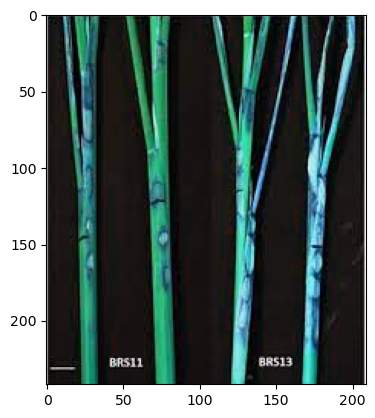

In [35]:

from keras.models import load_model

# Load the trained model


# Load and preprocess the input image
img = cv2.imread("222.jpeg")
img_resized = cv2.resize(img, (224, 224))
input_img_scaled = np.expand_dims(img_resized.astype('float32') / 255.0, axis=0)

# Get the prediction probabilities
preds = resnet_model.predict(input_img_scaled)[0]

# Determine the class label with the highest probability
class_idx = np.argmax(preds)
class_label = ['bacteria blight', 'brown leaf spot', 'false smut', 'sheath blight', 'blast'][class_idx]
accuracy = preds[class_idx]

i=0

if accuracy<0.85:
    class_label="Healthy Plant"
    i=1
    
# # Draw a rectangle around the disease area based on its coordinates
# x, y, w, h = 100, 100, 50, 50  # Change these values to the actual coordinates of the disease area
# cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)

# # Add text to the image indicating the predicted class label and its corresponding accuracy
# text = f"{class_label}: {accuracy:.2f}"
# cv2.putText(img, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

# # Display the resulting image
# cv2.imshow('Result', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [36]:

class_label

'sheath blight'

In [39]:
if i==1:
    msg="tell me that my rice plant is healthy in beautiful way"
else:
    msg = "{} disease found in my rice plants,what may be cause ,what are the possible remedies".format(class_label)
print("We have 5 diseases of Rice/Paddy in our Model.")
print("")
print("bacteria blight disease in Rice plant , brown leaf spot disease in Rice plant , smut disease in Rice plant ")
print("sheath blight disease in Rice plant , blast disease in Rice plant")
print("")
if i==1:
    print("Your plant is healthy")
else:
    print("{} is the disease found in the plant(uploaded image)".format(class_label))
print("")

import openai

openai.api_key = "Get a API Key from OpenAI and paste here"

output = openai.ChatCompletion.create(
  model="gpt-3.5-turbo", 
  messages=[{"role": "user", "content": msg}]
)

# Print out the whole output dictionary

# Get the output text only
print(output['choices'][0]['message']['content'])



We have 5 diseases of Rice/Paddy in our Model.

bacteria blight disease in Rice plant , brown leaf spot disease in Rice plant , smut disease in Rice plant 
sheath blight disease in Rice plant , blast disease in Rice plant

sheath blight is the disease found in the plant(uploaded image)

Cause: Sheath blight is a fungal disease caused by Rhizoctonia solani that affects rice plants.

Possible remedies:

1. Cultural control: Remove and destroy infected plants and debris to prevent the spread of the disease. Avoid over-fertilization and excess watering, as this can promote fungal growth.

2. Chemical control: Fungicides can be used to control the disease. Consult with a local agricultural extension office to determine the proper fungicide to use and apply it according to the instructions on the label.

3. Biological control: Trichoderma species can be used as a biological control agent to suppress the growth of Rhizoctonia solani.

4. Crop rotation: Rotate rice with other crops to break th